## CNN activation visualization

This notebook shows simple example for visualizing convolutional neural network internal activations.
Any layer that outputs 4D tensor (sample, rows, columns, channels) can be visualized. The code uses Tensorflow back-end channel order. The model used here is Keras pre-trained VGG16 with imagenet weights, but the same concept can be applied to any CNN model. 

The example photo used below is from a dog. It was chosen to study that how the imagenet trained model handles various parts of a dog picture. In imagenet 20% of the images are about dogs, so it is assumed that the model trained on imagenet will learn very thoroughly to analyze the dog pictures, which seems to be true. 

The code runs fast on a normal CPU, so this doesn't require GPU acceleration. 

The code is developed by Mikko Kursula in 2018. 
MIT License. 

In [1]:
import requests, math, io, sys, cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras import Model
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Global settings
IMG_SIZE = (224, 224)

## Get input image
Load image from web or from local disk.

In [3]:
# These methods are used to download or load image that is used to study the neural network activations. 
# Image is resized to square shape. If that distorts the aspect ratio too much, it would be best to crop the image. 

def download_image(url): 
    # Downloads image from web.
    try:
        r = requests.get(url, stream=True)
    except:
        print('Error in loading image')
        print(sys.exc_info()[0])
        return None
    try:
        img = np.asarray(Image.open(io.BytesIO(r.content)))
    except:
        print('Failed to parse image')
        print(sys.exc_info()[0])
        return None

    img = cv2.resize(img, IMG_SIZE)
    img_proc = np.expand_dims(img, axis=0).astype(np.float32)
    img_proc = preprocess_input(img_proc)

    # Return the normal rgb image and processed version of the image
    return img, img_proc

def load_image(filename):
    # Load image from local disk. 
    
    img = cv2.imread(filename)
    if(len(img.shape) > 2 and img.shape[2] == 4):
        # Get rid of the aplha channel in PNG files. 
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
    else:
        # Convert to RGB 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    img = cv2.resize(img, IMG_SIZE)
    img_proc = np.expand_dims(img, axis=0).astype(np.float32)
    img_proc = preprocess_input(img_proc)
    
    # Return the normal rgb image and processed version of the image
    return img, img_proc

In [4]:
# Use this to load image from web:
img, img_proc = download_image('https://images.pexels.com/photos/356378/pexels-photo-356378.jpeg')

In [5]:
# Use this to load image from disk:
img, img_proc = load_image('dog.jpg')

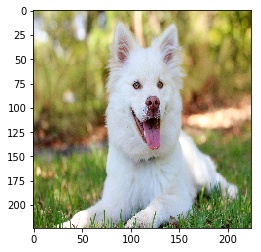

In [6]:
# Plot the image
plt.imshow(img)
plt.show()

## Initialize the model

In [7]:
# Initialize the model. Keras pre-trained VGG16 model is used in this example. It will be downloaded 
# from the web when using it the first time. 
model = VGG16(weights='imagenet')

In [8]:
# Run the model to get the image classification results. Top 5 predictions are displayed here. 
features = model.predict(img_proc)
labels = np.array(decode_predictions(features))
print(labels[:, :, 1])

[['Eskimo_dog' 'Samoyed' 'German_shepherd' 'white_wolf' 'Great_Pyrenees']]


In [9]:
# Print the model layers that have enough output dimensions to be plotted as image. 
print('These are the layers available for visualization:')
for i in range(len(model.layers)):
    if len(model.layers[i].output_shape) == 4:
        print(f'{i} = {model.layers[i].name}')

These are the layers available for visualization:
0 = input_1
1 = block1_conv1
2 = block1_conv2
3 = block1_pool
4 = block2_conv1
5 = block2_conv2
6 = block2_pool
7 = block3_conv1
8 = block3_conv2
9 = block3_conv3
10 = block3_pool
11 = block4_conv1
12 = block4_conv2
13 = block4_conv3
14 = block4_pool
15 = block5_conv1
16 = block5_conv2
17 = block5_conv3
18 = block5_pool


## Visualise the activations from selected layer

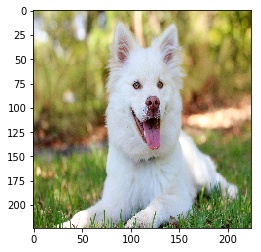

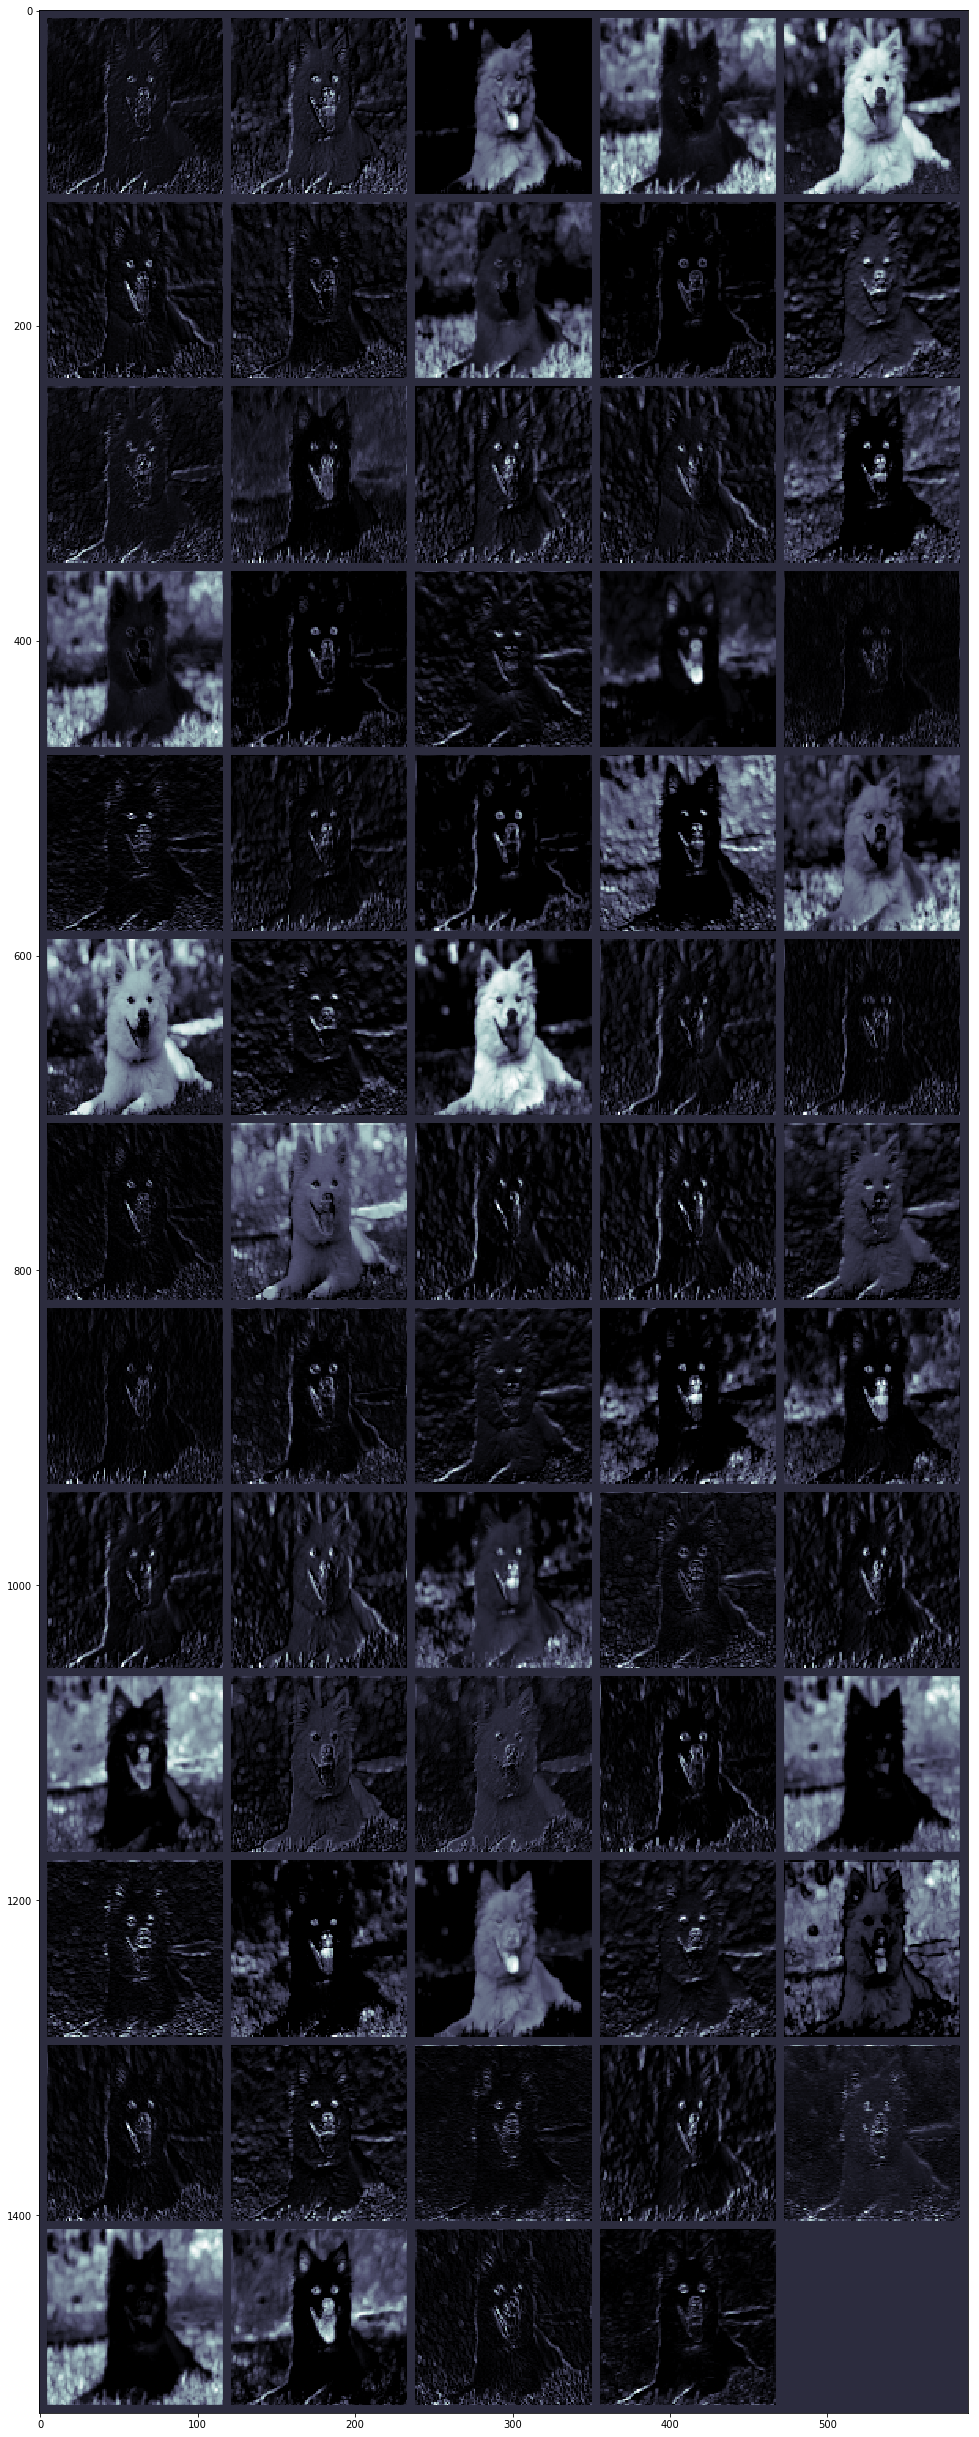

In [10]:
# Select the layer to visualize
visualization_layer = 3

# Setup a temporary model that contains the layers between the input and the selected visualization layer. 
temp_model = Model(inputs=model.input, outputs=model.layers[visualization_layer].output)
temp_output = temp_model.predict(img_proc)

# Get the output tensor dimensions 
img_y = temp_output.shape[1]
img_x = temp_output.shape[2]
n_filters = temp_output.shape[3]

# Setup the canvas and define the plot matrix
n_cols = 5
n_rows = int(n_filters / n_cols)
if n_cols * n_rows < n_filters:
    n_rows += 1
    
# Define border width. This is also the spacing between subplots. 
border_w = int(img_x / 10) + 1
if border_w > 5: border_w = 5

plt_shape = (border_w + n_rows * (img_y + border_w), border_w + n_cols * (img_x + border_w))
plt_canvas = np.full(plt_shape, .2)

# Plot the individual filter outputs to the plt_canvas
for idx in range(n_filters):
    # Scale the activation values to [0, 1] range. 
    subplot = temp_output[0, :, :, idx]
    subplot -= np.min(subplot)
    subplot /= (np.max(subplot) + 1e-6) # 1e-6 is to avoid divide by zero.
    
    # Calculate subplot coordinates on the plt_canvas
    i = idx % n_cols     
    j = int(idx / n_cols)
    y_start = border_w + j * (img_y + border_w)
    y_end = y_start + img_y
    x_start = border_w + i * (img_x + border_w)
    x_end = x_start + img_x
    
    # Copy the activations to the canvas. 
    plt_canvas[y_start:y_end, x_start:x_end ] = subplot

# Plot the input image for a reference
plt.imshow(img)
plt.show()
    
# Plot the activations matrix
plt.figure(figsize=(17, 17 * (n_rows/n_cols)))
plt.imshow(plt_canvas, cmap='bone')
plt.show()
